## Stacks batch 8 - filtering, m3 stacks-called genotypes

### Changes from original:
- **filter individuals first, then filter for missing loci**


<br>
Since I won't be using Marine's script here, I'll be running through the scripts I wrote for `batch 1`. Workflow:

1. Convert `populations` output to a 2x2 chart, with loci in rows
2. Filter for MAF
3. Filter out loci with missing data
4. Filter individuals for missing data
5. Filter loci out of HWE

<br>
#### 3/12/2018

### conversion to matrix

In [2]:
pwd

u'/mnt/hgfs/PCod-Compare-repo/notebooks/batch8_pipeline'

In [3]:
cd ../../scripts/PostStacksFilter_rSNP

/mnt/hgfs/PCod-Compare-repo/scripts/PostStacksFilter_rSNP


In [4]:
!python convert_genepop_to_matrix.py -h

usage: convert_genepop_to_matrix.py [-h] [-g GENEPOP] [-o OUTPUT]
                                    [-s STACKS_PATH]

convert populations genepop file into matrix for further filtering

optional arguments:
  -h, --help            show this help message and exit
  -g GENEPOP, --genepop GENEPOP
                        genepop file from populations
  -o OUTPUT, --output OUTPUT
                        output file
  -s STACKS_PATH, --stacks_path STACKS_PATH
                        path to the directory containing your stacks files


In [5]:
!python convert_genepop_to_matrix.py \
-g batch_8.genepop \
-o batch_8_matrix.txt \
-s ../../stacks_b8_wgenome_r05

working with genepop file:  batch_8.genepop
Stacks version 1.44; Genepop version 4.1.3; January 25, 2018

writing loci to output file...
writing genotypes to output file...
done.


In [6]:
!head transpose.py

## This script was written by Dan Drinan and transposes the rows and columns of a haplotype file
#python transpose.py batch_2_corrected_genotypes_2_alleles_genepop.txt batch_2_corrected_genotypes_2_alleles_genepop_transposed.txt

import sys

input_file = open(sys.argv[1], 'r')

header = True
matrix_of_data = []



In [7]:
!python transpose.py \
../../stacks_b8_wgenome_r05/batch_8_matrix.txt \
../../stacks_b8_wgenome_r05/batch_8_matrix_TRANSPOSED.txt

<br>
<br>
### How many Alleles per SNP?

In [8]:
infile = open("../../stacks_b8_wgenome_r05/batch_8_matrix_TRANSPOSED.txt", "r")

infile.readline()
transition = 0
transversion = 0
# 1 - A, 2 - C, 3 - G, 4 - T

for mystring in infile:
    stripped_string = mystring.strip('\n')
    all_genotypes = stripped_string.split(' ')[1:] #subset genotypes only from line
    alleles = []
    all_n_alleles = []
    for genotype in all_genotypes:
        a1 = int(genotype[0:2]) #separate genotype into two alleles
        a2 = int(genotype[2:])
        if a1 not in alleles and a1 != 0: #append allele to list IF it is unique and not 0
            alleles.append(a1)
        if a2 not in alleles and a2 != 0:
            alleles.append(a2)
    if (1 in alleles and 3 in alleles) or (2 in alleles and 4 in alleles):
        transition += 1
    elif (1 in alleles and 2 in alleles) or (3 in alleles and 4 in alleles):
        transversion += 1
    n_alleles = len(alleles) #find total number of alleles at locus 
    all_n_alleles.append(n_alleles) #append that number to list
infile.close()

In [9]:
import numpy as np
import matplotlib.pyplot as plt

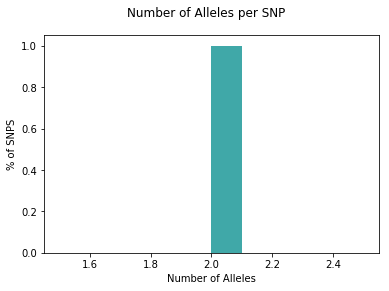

In [10]:
plt.hist(all_n_alleles, color = "darkcyan", alpha = 0.75)
plt.suptitle("Number of Alleles per SNP")
plt.xlabel("Number of Alleles")
plt.ylabel("% of SNPS")
plt.show()

In [10]:
plt.close()

<br>
<br>
### MAF Filtering
#### Run genepop to get INF file.
`Option 5 --> Suboption 1`

#### Parse genepop
Towards the end of the .INF file, allele frequencies are listed by population by locus, with one frequency table per locus. The script below parses this section into an "output frequency" file


*Note: open .INF file to check to make sure that all loci were processed*

In [11]:
!python parse_INF_file.py -h

usage: parse_INF_file.py [-h] [-f INPUT] [-p PATH_STACKS] [-pop POPS]
                         [-b BATCH]

parse .INF file from genepop to get allele frequences by population by locus

optional arguments:
  -h, --help            show this help message and exit
  -f INPUT, --input INPUT
                        .INF file
  -p PATH_STACKS, --path_stacks PATH_STACKS
                        path to stacks files, including .INF file
  -pop POPS, --pops POPS
                        text file with population names, one on each line.
                        make sure this is in the same order as the populations
                        listed in the .INF output file! (aka the order of your
                        populations in your pop map file)
  -b BATCH, --batch BATCH
                        stacks batch number


In [15]:
!python parse_INF_file.py \
-f batch_8_genepop.txt.INF \
-p ../../stacks_b8_wgenome_r05 \
-pop INF_populations.txt \
-b 8

You have a maximum of  2  alleles at one or more of your loci.
17  populations detected.
Heading written to output file. Now parsing allele frequencies...
Done.
Parsed allele frequencies in  21018  loci.


** Use Parsed INF to filter Transposed Matrix File **

In [16]:
!python filter_for_MAF_from_parsedINF.py -h

usage: filter_for_MAF_from_parsedINF.py [-h] [-inf INFINPUT]
                                        [-mat MATRIXINPUT] [-og OUTPUT_GOOD]
                                        [-ob OUTPUT_BAD]
                                        [-ofg OUTPUTFREQS_GOOD]
                                        [-ofb OUTPUTFREQS_BAD]
                                        [-p PATH_STACKS] [-a ALLELES]
                                        [-b BATCH]

filter for MAF using parsed .INF genepop file.

optional arguments:
  -h, --help            show this help message and exit
  -inf INFINPUT, --INFinput INFINPUT
                        parsed .INF file
  -mat MATRIXINPUT, --MATRIXinput MATRIXINPUT
                        half filtered matrix file that was used to make
                        genepop file
  -og OUTPUT_GOOD, --output_good OUTPUT_GOOD
                        output file, good loci
  -ob OUTPUT_BAD, --output_bad OUTPUT_BAD
                        output file, bad loci
  -ofg OUTPUTFREQS_

In [55]:
!python filter_for_MAF_from_parsedINF.py \
-inf batch_8_parseINF.txt \
-mat batch_8_matrix_TRANSPOSED.txt \
-og batch_8_filteredMAF.txt \
-ob batch_8_filteredMAF_bad.txt \
-ofg batch_8_filteredMAF_goodFreqs.txt \
-ofb batch_8_filteredMAF_badFreqs.txt \
-p ../../stacks_b8_wgenome_r05 \
-a 2 \
-b 8

7378  loci written to filtered output file.
Filtered out  13640  loci.


** Verify Filtering**

In [56]:
infile = open("../../stacks_b8_wgenome_r05/batch_8_filteredMAF_badFreqs.txt", "r")
infile.readline() # header

# save a1 frequencies by locus
bad_freqs_dict = {}
all_a1_freqs = []
for line in infile:
    locus = line.strip().split()[0]
    freqs = line.strip().split()[1:]
    a1_freqs = freqs[::2]
    bad_freqs_dict[locus] = a1_freqs
    for i in a1_freqs:
        if i != "-":
            all_a1_freqs.append(float(i))
infile.close()

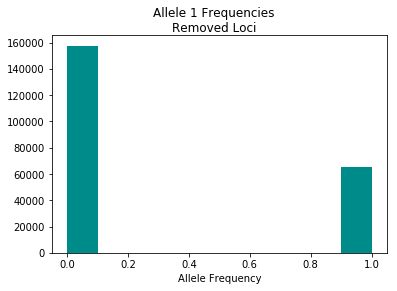

In [57]:
import numpy as np
import matplotlib.pyplot as plt
plt.hist(all_a1_freqs, color = "darkcyan")
plt.suptitle("Allele 1 Frequencies\nRemoved Loci")
plt.xlabel("Allele Frequency")
plt.show()

In [58]:
plt.close()

In [59]:
infile = open("../../stacks_b8_wgenome_r05/batch_8_filteredMAF_goodFreqs.txt", "r")
infile.readline() # header

# save a1 frequencies by locus
good_freqs_dict = {}
all_good_a1_freqs = []
locus_count = 0
good_locus_count = 0
for line in infile:
    locus = line.strip().split()[0]
    freqs = line.strip().split()[1:]
    a1_freqs = freqs[::2]
    a1_calc_freqs = [i for i in a1_freqs if i != "-"]
    a1_good_freqs = [i for i in a1_calc_freqs if float(i) < 0.95 and float(i) > 0.05]
    if len(a1_good_freqs) == 0:
        print "bad locus retained: ", locus
        print a1_calc_freqs
        print a1_good_freqs
    good_freqs_dict[locus] = a1_freqs
    for i in a1_good_freqs:
        if i != "-":
            all_good_a1_freqs.append(float(i))
infile.close()

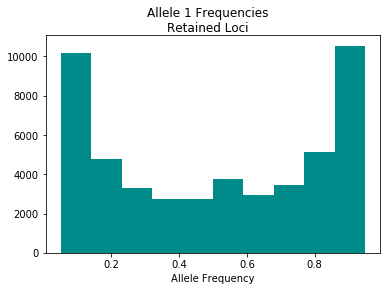

In [60]:
import numpy as np
import matplotlib.pyplot as plt
plt.hist(all_good_a1_freqs, color = "darkcyan")
plt.suptitle("Allele 1 Frequencies\nRetained Loci")
plt.xlabel("Allele Frequency")
plt.show()

In [61]:
plt.close()

<br>
<br>
### filter individuals for missing data

In [62]:
!python filter_individs_missing_data.py -h

usage: filter_individs_missing_data.py [-h] [-f INPUT] [-og OUTPUT_GOOD]
                                       [-ob OUTPUT_BAD]
                                       [-op OUTPUT_PROPORTIONS]
                                       [-s STACKS_PATH] [-p PERCENT]

filter individuals for missing data

optional arguments:
  -h, --help            show this help message and exit
  -f INPUT, --input INPUT
                        genotype file in 2 x 2 matrix; individuals as *column*
                        headers; will transpose
  -og OUTPUT_GOOD, --output_good OUTPUT_GOOD
                        output file containing 'good' loci
  -ob OUTPUT_BAD, --output_bad OUTPUT_BAD
                        output file containing 'bad' loci
  -op OUTPUT_PROPORTIONS, --output_proportions OUTPUT_PROPORTIONS
                        output file containing the missing data per individual
  -s STACKS_PATH, --stacks_path STACKS_PATH
                        path to the directory containing your stacks files
  -

In [64]:
!python filter_individs_missing_data.py \
-f batch_8_filteredMAF.txt \
-og batch_8_filteredMAF_filteredIndivids.txt \
-ob batch_8_filteredMAF_filteredIndivids_BAD.txt \
-op batch_8_filteredMAF_filteredIndivids_Freqs.txt \
-s ../../stacks_b8_wgenome_r05 \
-p 0.30

Transposing matrix...
calculating which individuals are missing too much data...
Deleting temporary file...
writing individuals to files...
done.
Total individuals processed:  679
Individuals retained:  644
Individuals removed:  35
Missing data info per individual can be found in the 'proportions' output file.


In [66]:
infile = open("../../stacks_b8_wgenome_r05/batch_8_filteredMAF_filteredIndivids_Freqs.txt", "r")
p_missing_list = []
infile.readline()
for line in infile:
    p_missing_list.append(float(line.strip().split()[2]))
infile.close()

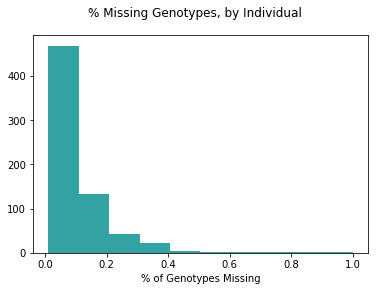

In [67]:
plt.hist(p_missing_list, color="darkcyan", alpha= 0.80)
plt.suptitle("% Missing Genotypes, by Individual")
plt.xlabel("% of Genotypes Missing")
plt.show()

In [68]:
plt.close()

*Verified missing data calculation and number of individuals that should be filtered out*

<br>
<br>
### Filter Loci for Missing data

In [69]:
!python filter_loci_missing_data.py -h

usage: filter_loci_missing_data.py [-h] [-f INPUT] [-og OUTPUT_GOOD]
                                   [-ob OUTPUT_BAD] [-op OUTPUT_PROPORTIONS]
                                   [-s STACKS_PATH] [-p PERCENT]

filter loci for missing data

optional arguments:
  -h, --help            show this help message and exit
  -f INPUT, --input INPUT
                        genotype file in 2 x 2 matrix
  -og OUTPUT_GOOD, --output_good OUTPUT_GOOD
                        output file containing 'good' loci
  -ob OUTPUT_BAD, --output_bad OUTPUT_BAD
                        output file containing 'bad' loci
  -op OUTPUT_PROPORTIONS, --output_proportions OUTPUT_PROPORTIONS
                        output file containing the missing data per locus
  -s STACKS_PATH, --stacks_path STACKS_PATH
                        path to the directory containing your stacks files
  -p PERCENT, --percent PERCENT
                        threshold to remove missing data: ___ percent or more
                        missi

In [75]:
!python filter_loci_missing_data.py \
-f batch_8_filteredMAF_filteredIndivids.txt \
-og batch_8_filteredMAF_filteredIndivids_filteredLoci.txt \
-ob batch_8_filteredMAF_filteredIndivids_filteredLoci_bad.txt \
-op batch_8_filteredMAF_filteredIndivids_filteredLoci_freqs.txt \
-s ../../stacks_b8_wgenome_r05 \
-p 0.30

Transposing matrix...
calculating 'good' and 'bad' loci...
writing 'good' and 'bad' loci to files...
done.
Total loci:  7378
Loci retained:  6733
Loci removed:  645
Missing data info per locus can be found in the 'proportions' output file.


In [76]:
infile = open("../../stacks_b8_wgenome_r05/batch_8_filteredMAF_filteredIndivids_filteredLoci_freqs.txt", "r")
p_missing_list = []
infile.readline()
for line in infile:
    p_missing_list.append(float(line.strip().split()[2]))
infile.close()

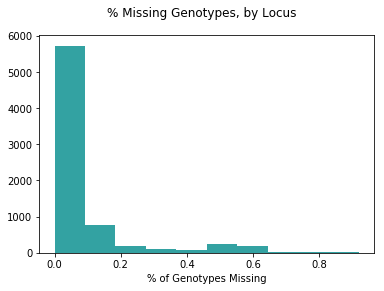

In [77]:
plt.hist(p_missing_list, color="darkcyan", alpha= 0.80)
plt.suptitle("% Missing Genotypes, by Locus")
plt.xlabel("% of Genotypes Missing")
plt.show()

In [78]:
plt.close()

<br>

So I have **644 individuals** and **6733 loci**.

<br>
<br>
### filter for HWE

see [this notebook](https://github.com/mfisher5/PCod-Compare-repo/blob/master/notebooks/batch8_pipeline/Stacks%20batch%208%20-%20m3%20HWE%20final%20filter.ipynb)


